In [1]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/kaggle/input/skin-cancer/data/train")
data_dir_test = pathlib.Path("/kaggle/input/skin-cancer/data/train")

In [3]:
# Here we have the 2637 train and 660 test
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("The number of Train data:",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("The Number of Test data:",image_count_test)

The number of Train data: 2637
The Number of Test data: 2637


In [4]:
# This Parameter we can use it in the network and model
batch_size = 32
img_height = 180
img_width = 180

In [5]:
# For train data set
train_ds = image_dataset_from_directory(data_dir_train, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 2637 files belonging to 2 classes.
Using 2110 files for training.


In [6]:
# here we can put the validate data
val_ds = image_dataset_from_directory(data_dir_train, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 2637 files belonging to 2 classes.
Using 527 files for validation.


In [7]:
# Here We give the name of the data the we found the Benign dataset and malignant
class_names = train_ds.class_names
print(type(class_names), class_names)

<class 'list'> ['benign', 'malignant']


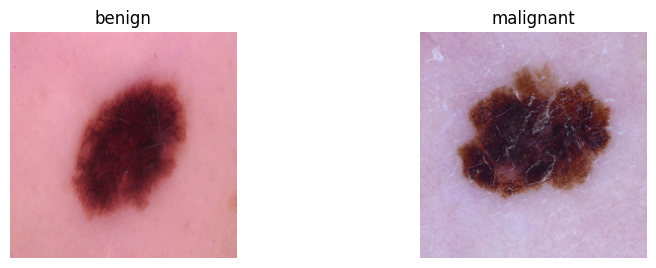

In [8]:
## Visualizing the training data

plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[10]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

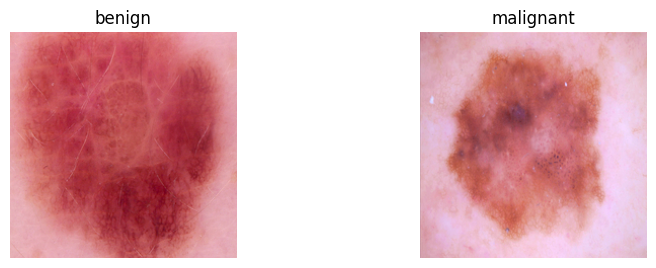

In [9]:
### Visualizing the test data

plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_test), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [10]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [11]:
# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('CPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [12]:
"""Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

   Dataset.prefetch() overlaps data preprocessing and model execution while training."""

data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
print("The shape of val:",val_ds)

The shape of val: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#B6EADA;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'></a></div></center>

<a id='3'></a>
# Convolutional Neural Network (CNN)
<div style='border-top-width: 2px;
           border-color:#B6EADA;
           border-style: solid;'></div>
<br>

A Convolutional Neural Network (CNN) is a machine learning network architecture used in deep learning tasks. CNNs are useful for solving computer vision tasks as it is capable of identifying patterns in image data relating to classifcation, object detection, image segmentation and more. CNNs consist of convolutional layers which are used to extract features from image data. For classfication problems, CNNs include a fully-connected classification head which uses the extracted features generated by the convolutional layers to complete the task of classifying the input image. In this section we'll use a basic CNN as our baseline model for skin cancer detection. 

<center>
    <figure>
        <img src="https://i.postimg.cc/zGCZTpnp/Overview-and-details-of-a-convolutional-neural-network-CNN-architecture-for-image.png" alt ="Convolutional Neural Network" style='height:500px;width:550px;'>
        <figcaption>
            Image Source: <a href="https://www.researchgate.net/figure/Overview-and-details-of-a-convolutional-neural-network-CNN-architecture-for-image_fig2_341576780">[Source]</a></figcaption>
    </figure>
</center> 

<a id="3.1"></a>
### Where to learn more about Convolutional Neural Networks?
This notebook does not conver the explanation of Convolutional Neural Networks in great detail. Hence, here's a link to an interactive educational guide on Convolutional Neural Networks and Convolutional Layers which may prove to useful.

<center>
    <figure>
        <img src="https://i.postimg.cc/3N1dFj8j/convlayer-detailedview-demo.gif" alt ="Conv" style='width: 500px;'>
        <figcaption>
            GIF Source: <a href="https://poloclub.github.io/cnn-explainer/">[Source]</a></figcaption>
    </figure>
</center>

> Link to guide: [Learn Convolutional Neural Network (CNN) in your browser!](https://poloclub.github.io/cnn-explainer/)

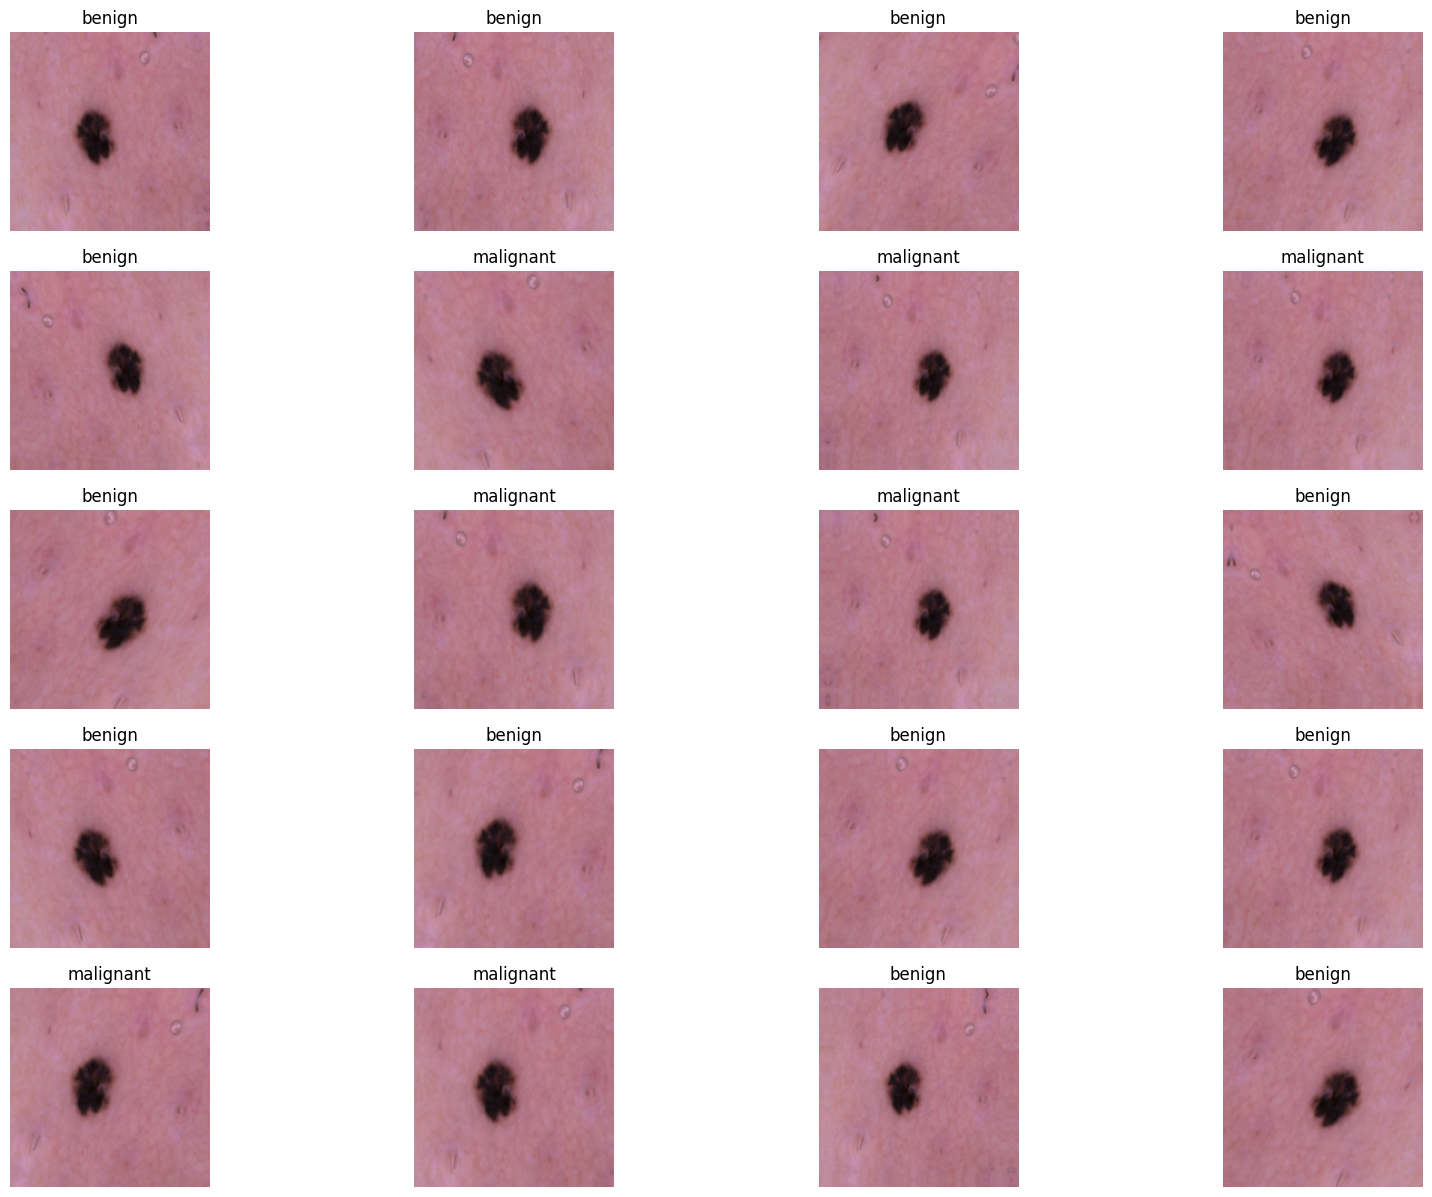

In [15]:
# Compile the model and show some of image after make augmentation
plt.figure(figsize=(20, 15))
for images, label in train_ds.take(1):
    for i in range(20):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [16]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = data_augmentation
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [17]:
# Compile the model 

## Your code goes here
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 180, 180, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

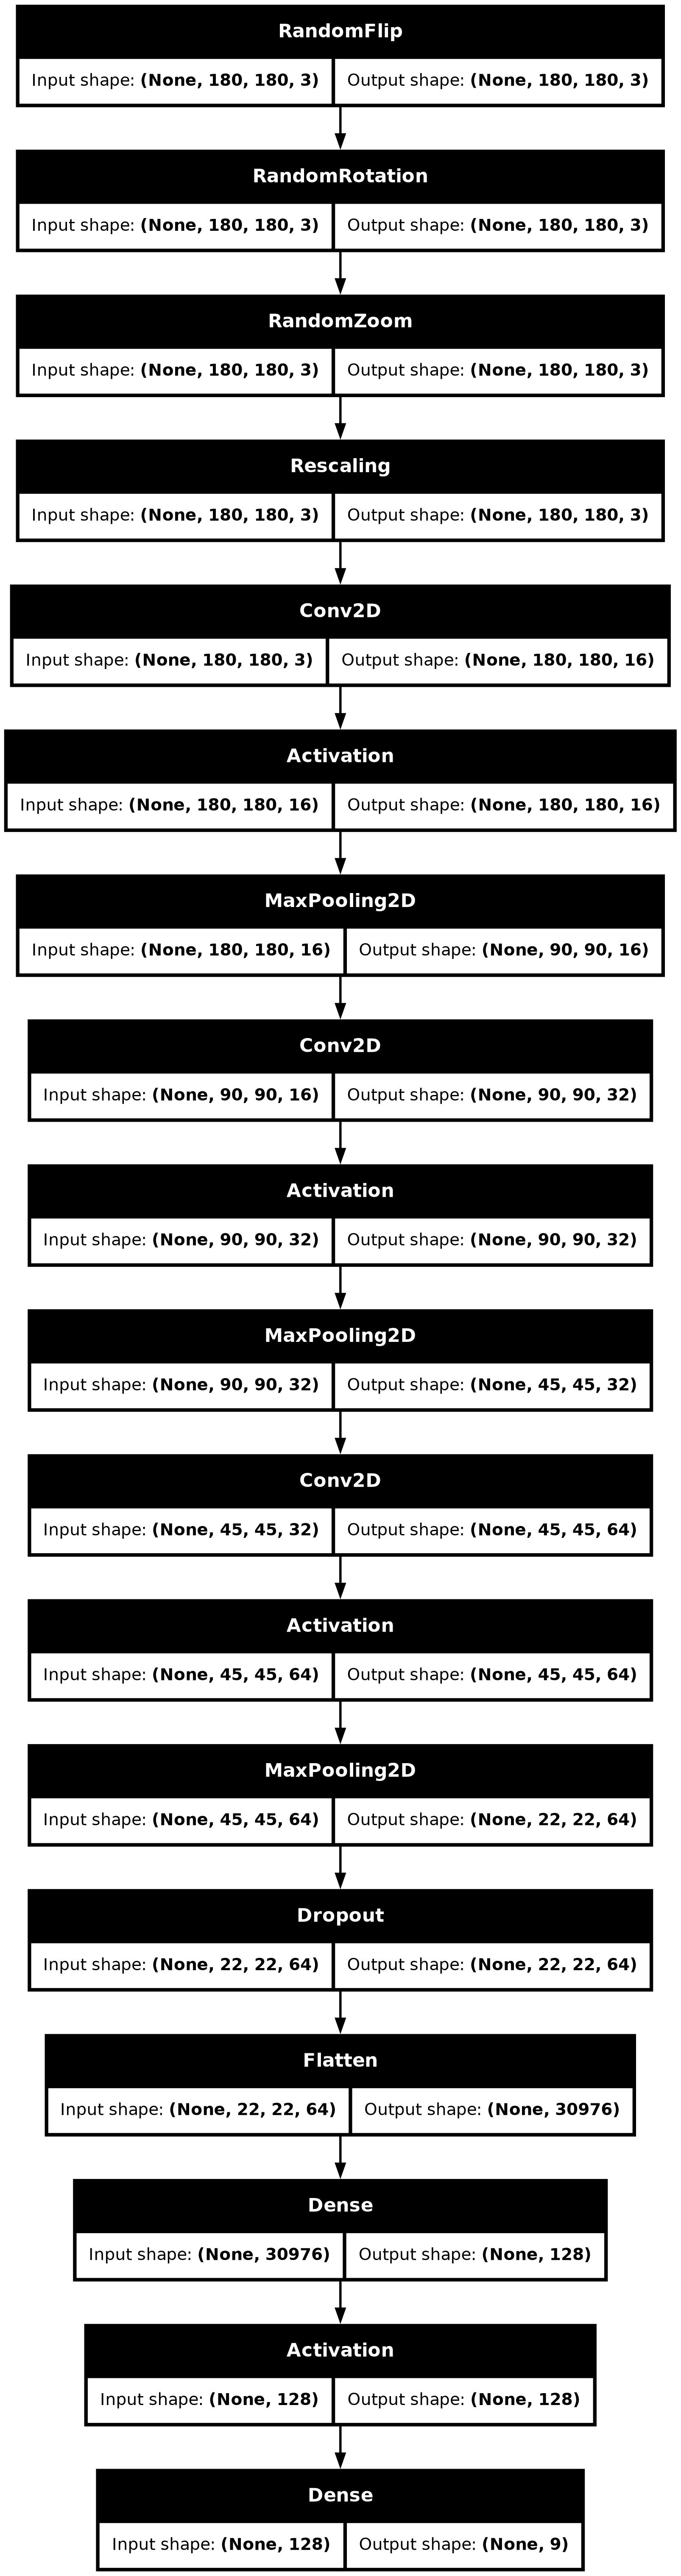

In [19]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='cnn-mnist.png', show_shapes=True)

In [20]:
epochs = 50 #100

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


2024-08-26 13:14:17.128102: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.5556 - loss: 1.0167 - val_accuracy: 0.6660 - val_loss: 0.5217
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7212 - loss: 0.5004 - val_accuracy: 0.7287 - val_loss: 0.4621
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7872 - loss: 0.4259 - val_accuracy: 0.8065 - val_loss: 0.4009
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7716 - loss: 0.4451 - val_accuracy: 0.8046 - val_loss: 0.4057
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7842 - loss: 0.4213 - val_accuracy: 0.8140 - val_loss: 0.3748
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7951 - loss: 0.3999 - val_accuracy: 0.8254 - val_loss: 0.3834
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8166 - loss: 0.3756 - val_accuracy: 0.8178 - val_loss: 0.3697
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8154 - loss: 0.3928 - val_accuracy: 0.8235 - val_loss: 0.

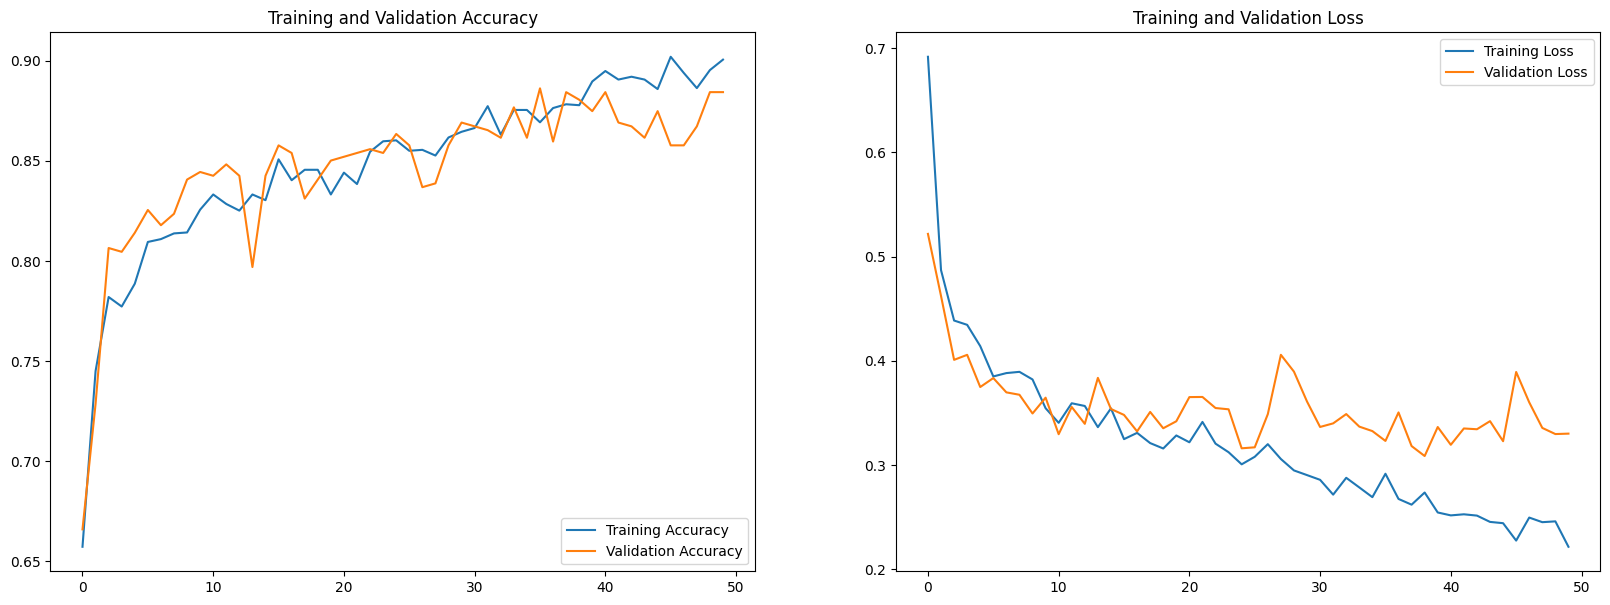

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
#model.save('model.h5')

In [23]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'benign': 1440, 'malignant': 1197}

In [24]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

NumberOfSamples
benign                1440
malignant             1197

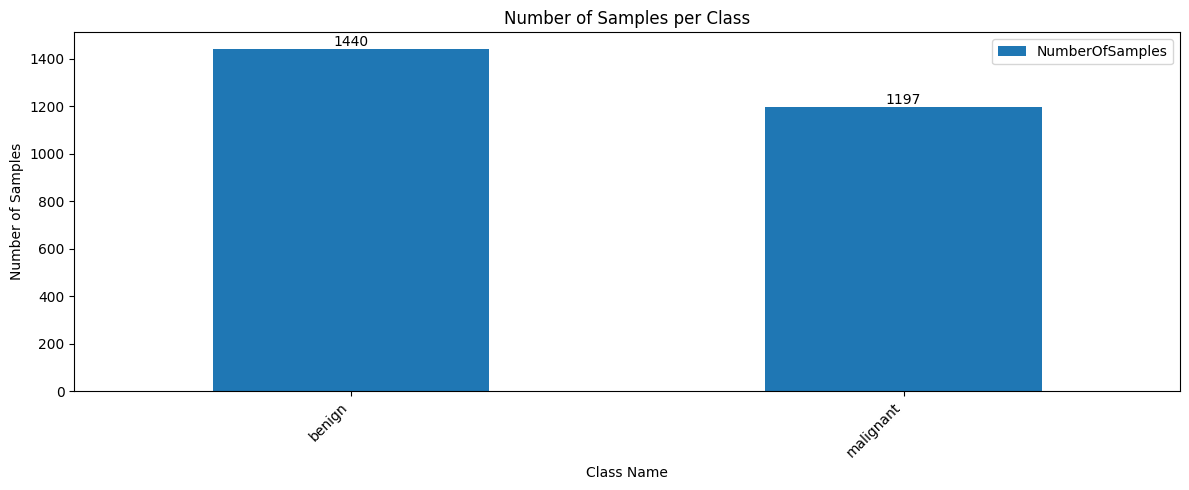

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you've already created class_size dictionary
class_df = pd.DataFrame(class_size.items(), columns=['ClassName', 'NumberOfSamples'])
class_df.set_index('ClassName', inplace=True)

# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 5))
bars = class_df.plot.bar(ax=ax)

# Add value labels on top of each bar
for i, v in enumerate(class_df['NumberOfSamples']):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Customize the plot
plt.title('Number of Samples per Class')
plt.xlabel('Class Name')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
test_dataset = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), 
                                           batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 2637 files belonging to 2 classes.


In [27]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
Labels:
 [1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0]


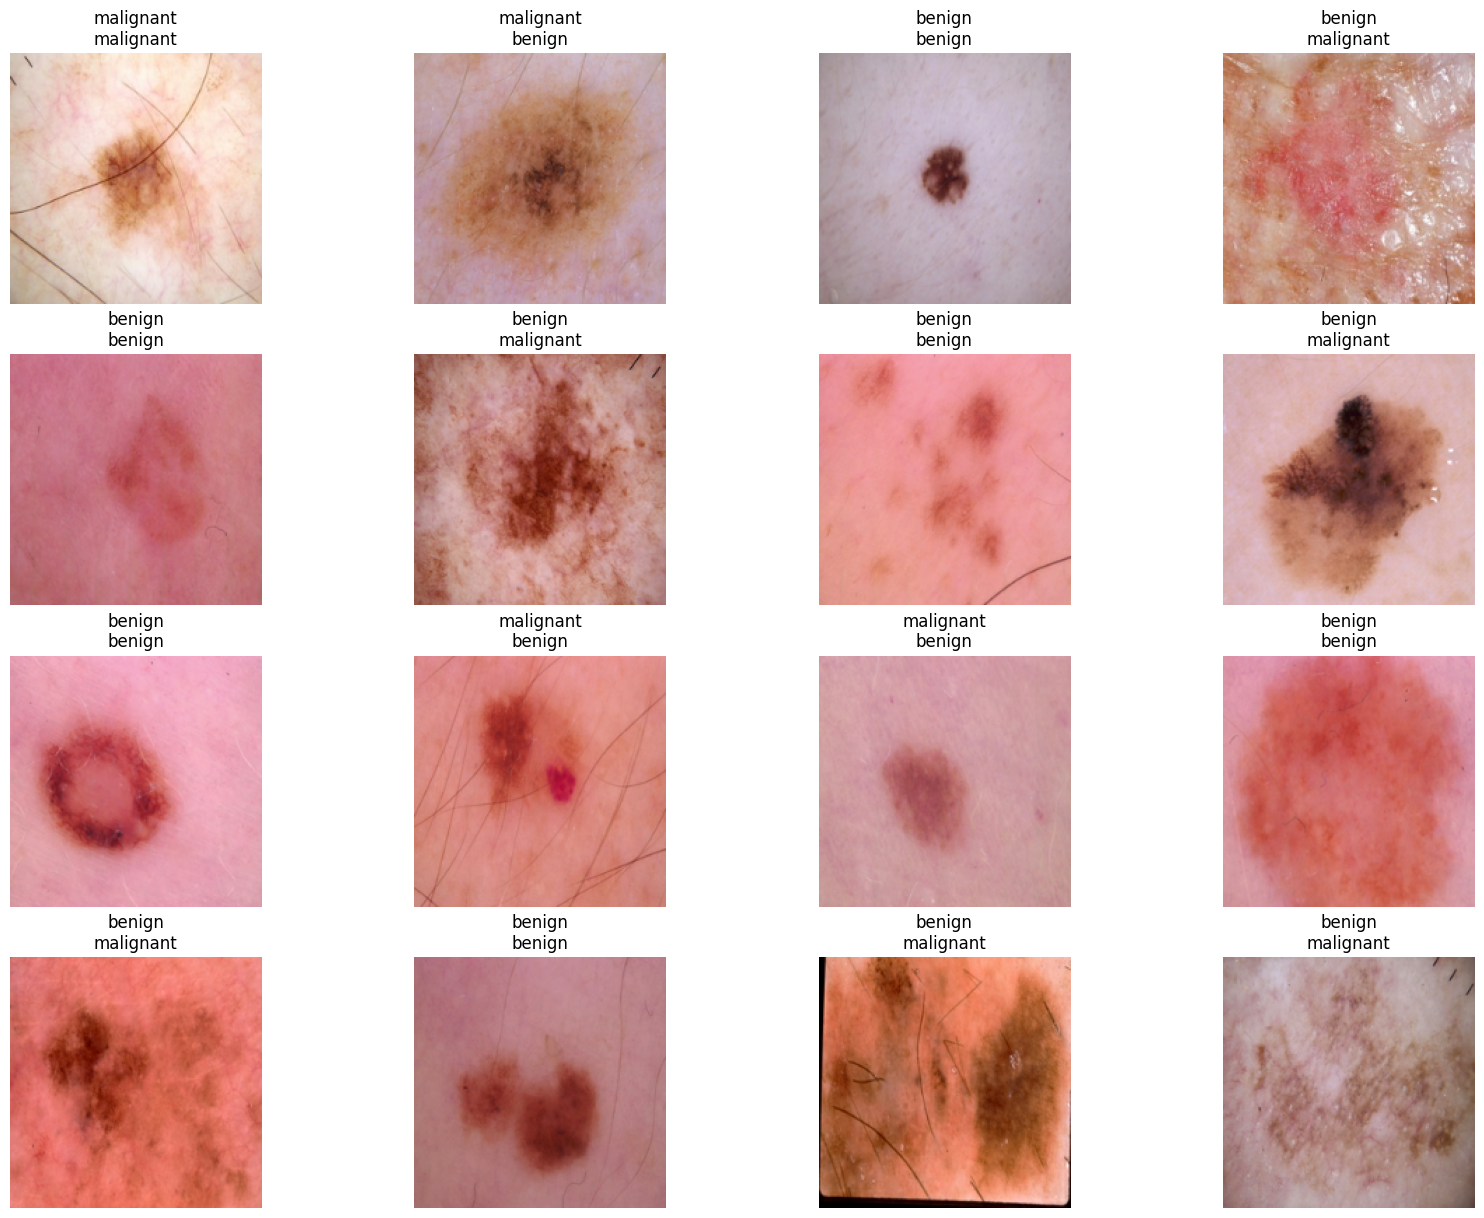

In [28]:
plt.figure(figsize=(20, 15))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")